# BERT Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 23.8 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 26.0 MB/s 
     |████████████████████████████████| 965 kB 54.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
from transformers import BertModel, BertTokenizer

In [ ]:
data_embedding = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/processed_data_deleted.csv")
data_embedding.drop("Unnamed: 0", inplace=True, axis=1)
data_embedding.head()

,comment,rating
0,màu xanh ở ngoài nhìn đẹp sang thích hợp cho n...,1
1,đóng gói cẩn thận giao đúng lúc giờ đúng sản p...,1
2,hộp bên ngoài hộp giấy tiki á hơi bị móp xíu b...,1
3,rất tốt nha và coi để độ bền nhưng thấy máy rấ...,1
4,hang giao con niem phong nhưng su dung duc thô...,1


In [ ]:
from google.colab import data_table
data_table.DataTable(data_embedding, include_index=False, num_rows_per_page=10)

,comment,rating
0,màu xanh ở ngoài nhìn đẹp sang thích hợp cho n...,1
1,đóng gói cẩn thận giao đúng lúc giờ đúng sản p...,1
2,hộp bên ngoài hộp giấy tiki á hơi bị móp xíu b...,1
3,rất tốt nha và coi để độ bền nhưng thấy máy rấ...,1
4,hang giao con niem phong nhưng su dung duc thô...,1
...,...,...
7108,ghế khá yếu nghiêng về phía trước ngồi cảm giá...,-1
7109,không có ốc thì làm sao mag lắp,-1
7110,ốc không khớp,-1
7111,giao sài màu yeu cầu cua khách alo cho cửa hàn...,-1


# Embedding

In [ ]:
from pyvi.ViTokenizer import tokenize

data_embedding['comment'] = data_embedding['comment'].apply(lambda x: tokenize(str(x)))
data_embedding.head()

,comment,rating
0,màu xanh ở ngoài nhìn đẹp sang thích_hợp cho n...,1
1,đóng_gói cẩn_thận giao đúng lúc giờ đúng sản_p...,1
2,hộp bên ngoài hộp giấy tiki á hơi bị móp xíu b...,1
3,rất tốt nha và coi để độ bền nhưng thấy máy rấ...,1
4,hang giao con niem phong nhưng su dung duc thô...,1


In [ ]:
data_embedding['rating'].value_counts()

 1    3002
-1    2676
 0    1435
Name: rating, dtype: int64

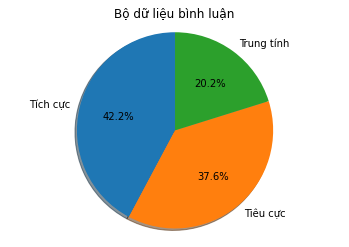

In [ ]:
import matplotlib.pyplot as plt
data = [3002, 2676, 1435]
label = ['Tích cực', 'Tiêu cực', 'Trung tính']
 
plt.pie(data, labels=label, autopct='%1.1f%%', explode=[0, 0, 0], shadow=True, startangle=90)
plt.title('Bộ dữ liệu bình luận')
plt.axis('equal')
plt.show()

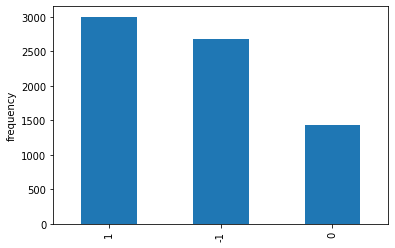

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
data_embedding['rating'].value_counts().plot(ax = ax, kind = 'bar', ylabel = 'frequency')
plt.show()

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")


Downloading:   0%|          | 0.00/270 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at VoVanPhuc/sup-SimCSE-VietNamese-phobert-base were not used when initializing RobertaModel: ['mlp.dense.weight', 'mlp.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def extract_features(s):
  vector = ""
  inputs = PhobertTokenizer(s, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
      doc = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
  return doc[0].numpy()
  
def convert_to_array(data_frame, col):
  return np.array(data_frame[col].tolist())

from tqdm import tqdm
tqdm.pandas()

def vector_column(data_frame, col1, col2):
  data_frame[col2] = data_frame[col1].progress_apply(lambda x: np.array(extract_features(x))) 
  return data_frame

In [ ]:
data_embedding_ = vector_column(data_embedding, 'comment', 'vector')

100%|██████████| 7113/7113 [12:03<00:00,  9.82it/s]


In [ ]:
data_embedding_.to_csv('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/data_embedding_.csv')

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/phobert_embedding_3class_variable.npy', data_embedding, allow_pickle=True)

In [ ]:
X_data = convert_to_array(data_embedding_, 'vector')
np.save('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/phobert_embedding_3class.npy', X_data, allow_pickle=True)

In [ ]:
X_data = convert_to_array(data_embedding_, 'vector')

# Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import seaborn as sns

In [ ]:
X_data = np.load('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/phobert_embedding_3class.npy', allow_pickle=True)

In [ ]:
data_embedding_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/data_embedding_.csv')

In [ ]:
data_embedding_.drop("Unnamed: 0", inplace = True, axis = 1)
data_embedding_.head()

,comment,rating,vector
0,màu xanh ở ngoài nhìn đẹp sang thích_hợp cho n...,2,[-0.06105313 0.32824582 0.11574502 -0.064779...
1,đóng_gói cẩn_thận giao đúng lúc giờ đúng sản_p...,2,[-1.62013128e-01 3.46394032e-01 -3.22780609e-...
2,hộp bên ngoài hộp giấy tiki á hơi bị móp xíu b...,2,[ 0.000992 0.41857904 -0.2581509 -0.186687...
3,rất tốt nha và coi để độ bền nhưng thấy máy rấ...,2,[-8.24319571e-03 3.04159909e-01 3.14256586e-...
4,hang giao con niem phong nhưng su dung duc thô...,2,[ 0.18767421 0.42636946 -0.26861045 -0.056577...


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_embedding_['rating'] = le.fit_transform(data_embedding_['rating'].astype(str))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


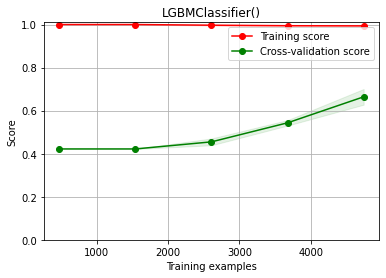

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

!pip install lightgbm

from lightgbm import LGBMClassifier

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

lgb = LGBMClassifier()
std = StandardScaler()
x = X_data
y = data_embedding_['rating']

title = lgb
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
plt = plot_learning_curve(lgb, title, x, y, cv=3, ylim=(0.0, 1.01), n_jobs=1)
plt.show()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

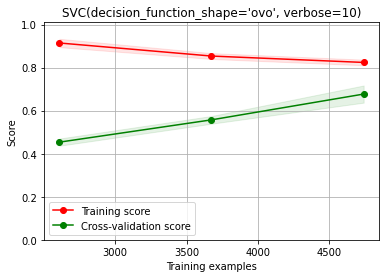

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np



def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from sklearn.svm import SVC

svc_model = SVC(decision_function_shape = 'ovo', verbose=10)
# lgb = LGBMRegressor(min_data=1,random_state=5, n_jobs=1)
std = StandardScaler()
x = X_data
y = data_embedding_['rating']

title = svc_model
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
plt = plot_learning_curve(svc_model, title, x, y, cv=3, ylim=(0.0, 1.01), n_jobs=1)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data, data_embedding_['rating'], test_size=0.1, shuffle=True) 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'Tiêu cực': {'precision': 0.66875, 'recall': 0.7925925925925926, 'f1-score': 0.7254237288135594, 'support': 270}, 'Trung tính': {'precision': 0.4883720930232558, 'recall': 0.27450980392156865, 'f1-score': 0.3514644351464435, 'support': 153}, 'Tích cực': {'precision': 0.7875816993464052, 'recall': 0.8339100346020761, 'f1-score': 0.8100840336134454, 'support': 289}, 'accuracy': 0.6980337078651685, 'macro avg': {'precision': 0.6482345974565537, 'recall': 0.6336708103720792, 'f1-score': 0.6289907325244828, 'support': 712}, 'weighted avg': {'precision': 0.6782226704265019, 'recall': 0.6980337078651685, 'f1-score': 0.67942802116763, 'support': 712}}


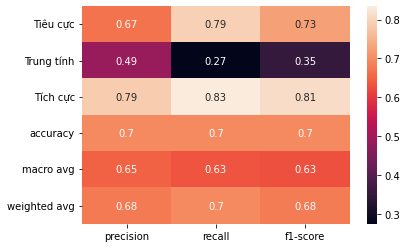

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(x_train, y_train)

y_predict = lr_model.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

[LibSVM]{'Tiêu cực': {'precision': 0.6572237960339944, 'recall': 0.8592592592592593, 'f1-score': 0.7447833065810595, 'support': 270}, 'Trung tính': {'precision': 0.5333333333333333, 'recall': 0.20915032679738563, 'f1-score': 0.3004694835680751, 'support': 153}, 'Tích cực': {'precision': 0.7959866220735786, 'recall': 0.8235294117647058, 'f1-score': 0.8095238095238095, 'support': 289}, 'accuracy': 0.7050561797752809, 'macro avg': {'precision': 0.6621812504803021, 'recall': 0.6306463326071169, 'f1-score': 0.6182588665576481, 'support': 712}, 'weighted avg': {'precision': 0.6869249420062398, 'recall': 0.7050561797752809, 'f1-score': 0.6755838549370542, 'support': 712}}


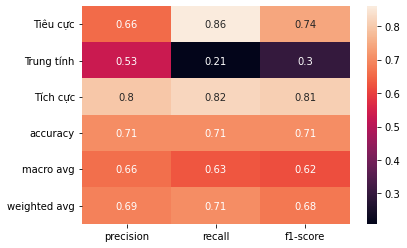

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(decision_function_shape = 'ovo', verbose=10)
# , class_weight = {0:5, 1:0, 2:1.5, 3:1.5, 4:5}
svc_model.fit(x_train, y_train)

y_predict = svc_model.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

{'Tiêu cực': {'precision': 0.6246719160104987, 'recall': 0.8814814814814815, 'f1-score': 0.7311827956989247, 'support': 270}, 'Trung tính': {'precision': 0.5, 'recall': 0.11764705882352941, 'f1-score': 0.19047619047619047, 'support': 153}, 'Tích cực': {'precision': 0.7932203389830509, 'recall': 0.8096885813148789, 'f1-score': 0.8013698630136986, 'support': 289}, 'accuracy': 0.6882022471910112, 'macro avg': {'precision': 0.6392974183311831, 'recall': 0.6029390405399633, 'f1-score': 0.5743429497296045, 'support': 712}, 'weighted avg': {'precision': 0.6662950776530006, 'recall': 0.6882022471910112, 'f1-score': 0.6434804808883788, 'support': 712}}


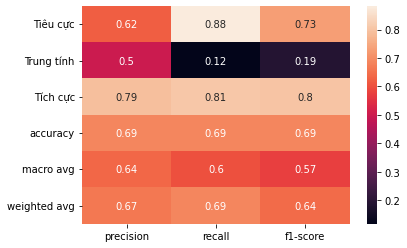

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=None, random_state=0)
rfc.fit(x_train, y_train)

y_predict = rfc.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'Tiêu cực': {'precision': 0.6253869969040248, 'recall': 0.7481481481481481, 'f1-score': 0.6812816188870152, 'support': 270}, 'Trung tính': {'precision': 0.3924050632911392, 'recall': 0.20261437908496732, 'f1-score': 0.2672413793103448, 'support': 153}, 'Tích cực': {'precision': 0.7483870967741936, 'recall': 0.8027681660899654, 'f1-score': 0.7746243739565943, 'support': 289}, 'accuracy': 0.6530898876404494, 'macro avg': {'precision': 0.5887263856564525, 'recall': 0.5845102311076936, 'f1-score': 0.5743824573846514, 'support': 712}, 'weighted avg': {'precision': 0.6252476612575463, 'recall': 0.6530898876404494, 'f1-score': 0.6301972081565065, 'support': 712}}


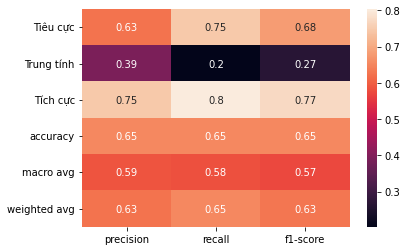

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test)

params = {
    'max_depth': 100,
    'objective': 'multi:softmax',  
    'num_class': 3,
    'n_gpus': 0,
    'learning_rate': 0.3,
    'n_estimators': 100,
    'eta':0.1,
    'subsample':0.3
}
# num_round = 2

# cv_analysis = xgb.cv(params, dtrain, num_round, nfold=5, seed=0)

bst = xgb.train(params, dtrain)

y_predict = bst.predict(dtest)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# LightGBM

{'Tiêu cực': {'precision': 0.6392045454545454, 'recall': 0.8333333333333334, 'f1-score': 0.7234726688102894, 'support': 270}, 'Trung tính': {'precision': 0.5, 'recall': 0.22875816993464052, 'f1-score': 0.31390134529147984, 'support': 153}, 'Tích cực': {'precision': 0.803448275862069, 'recall': 0.8062283737024222, 'f1-score': 0.8048359240069085, 'support': 289}, 'accuracy': 0.6924157303370787, 'macro avg': {'precision': 0.6475509404388715, 'recall': 0.6227732923234653, 'f1-score': 0.6140699793695593, 'support': 712}, 'weighted avg': {'precision': 0.6759575547708782, 'recall': 0.6924157303370787, 'f1-score': 0.6684861073684987, 'support': 712}}


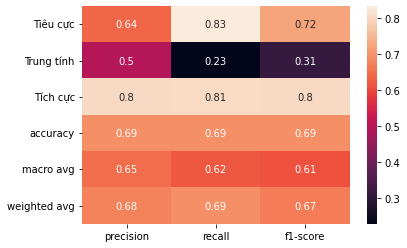

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

model_ltb = lgb.LGBMClassifier()
model_ltb.fit(x_train, y_train)
y_predict = model_ltb.predict(x_test)
clf_report = classification_report(y_test, y_predict, labels= [0,1,2],
                                   target_names=['Tiêu cực', 'Trung tính', 'Tích cực'], output_dict=True)
print(clf_report)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [ ]:
# params_ltb = {
#     'max_depth': 10,
#     'objective': 'multiclass',  
#     'metric': 'multi_logloss',
#     'num_class': 3,
#     'is_unbalanced': True,
#     'n_gpus': 0,
#     'boosting': 'gbdt',
#     'lambda_l2': 0.01,
#     'learning_rate': 0.03,
#     'num_leaves': 183,
#     'min_data_in_leaf': 18,
#     'verbosity': -1,
# }
# num_rounds = 1

In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
# y_predict_ltb = 0

In [ ]:
# counter = 0

# for train, val in kfold.split(X_data, data_embedding_['rating']):
#     counter += 1
#     train_x, train_y = X_data[train], data_embedding_['rating'][train]
#     test_x, test_y = X_data[val], data_embedding_['rating'][val]
#     lgtrain = ltb.Dataset(train_x, label = train_y.ravel())
#     lgval = ltb.Dataset(test_x, label = test_y.ravel())
#     model_ltb= ltb.train(params_ltb, lgtrain, num_rounds, valid_sets = [lgtrain, lgval])
#     pred = model_ltb.predict(test_x, num_iteration = model_ltb.best_iteration)
#     y_predict_ltb = y_predict_ltb + pred
# y_predict_ltb = y_predict_ltb/float(counter)

In [ ]:
# print(classification_report(y_test, pred + 1, labels= [0,1,2], digits = 4))

In [ ]:
model_ltb.fit(x_train, y_train)
y_predict = model_ltb.predict(x_test)
print(classification_report(y_test, y_predict, labels= [0,1,2], digits = 4))

              precision    recall  f1-score   support

           0     0.6971    0.8258    0.7560       287
           1     0.5139    0.2467    0.3333       150
           2     0.7600    0.8291    0.7930       275

    accuracy                         0.7051       712
   macro avg     0.6570    0.6338    0.6275       712
weighted avg     0.6828    0.7051    0.6813       712



In [ ]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
plt.style.use('ggplot')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, data_embedding_['rating'], test_size=0.2, shuffle=True) 
kfold = model_selection.KFold(n_splits=10, random_state=None)

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('LGBM', LGBMClassifier()))

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
      kfold = model_selection.KFold(n_splits=5, random_state=None)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.702812 (0.006098)
SVM: 0.730931 (0.010087)
LGBM: 0.718805 (0.007518)


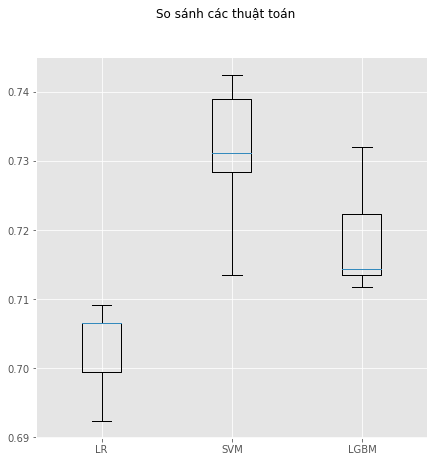

In [ ]:
fig = plt.figure(figsize=(7,7))
fig.suptitle('So sánh các thuật toán')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()